In [1]:
import os
import pandas as pd
from sentence_transformers import SentenceTransformer
import re
import preprocessor as p
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyplotz.pyplotz import PyplotZ

c:\Users\yobsa\anaconda3\envs\ICD\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('alarm_df.csv')
df= df[["alarmtitle"]]
df

,alarmtitle
0,端口链路协商不成功
1,链路断开
2,内存不可纠正错误告警
3,接口IPv4协议态down
4,端口存在丢包
...,...
90707,iSCSI链路异常
90708,iSCSI链路异常
90709,iSCSI链路异常
90710,接口IPv4协议态down


In [3]:
frame = list(df['alarmtitle'])
#frame = frame[0:10000]

In [4]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embedder = model.encode(frame, show_progress_bar=True)

Batches: 100%|██████████| 2835/2835 [16:39<00:00,  2.84it/s] 


In [5]:
embedder

array([[-0.7281959 , -0.2198462 ,  0.39794806, ..., -0.3337048 ,
        -0.34888527,  0.14092511],
       [-0.82152647,  0.21108723,  0.67746645, ..., -0.41926953,
        -0.20426917,  0.03307243],
       [-0.7954255 ,  0.19882822,  0.8118523 , ..., -0.1917388 ,
        -0.2275241 , -0.00208029],
       ...,
       [-0.9477538 ,  0.2594484 ,  0.88580614, ..., -0.5510247 ,
         0.03561125,  0.5997592 ],
       [-1.1328263 , -0.24680324,  0.3987696 , ..., -0.36615008,
        -0.06288924,  0.354933  ],
       [-1.1328263 , -0.24680324,  0.3987696 , ..., -0.36615008,
        -0.06288924,  0.354933  ]], dtype=float32)

In [6]:
num_clusters = 5
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(embedder)

KMeans(n_clusters=5)

In [7]:
# save the model
import pickle
pickle.dump(clustering_model, open("clustering_model.pkl", "wb"))



In [8]:
# load the model
model = pickle.load(open("clustering_model.pkl", "rb"))
cluster_assignment = clustering_model.labels_
cluster_assignment

array([0, 3, 0, ..., 3, 2, 2])

In [9]:
cluster_df = pd.DataFrame(frame, columns = ['frame'])
cluster_df['cluster'] = cluster_assignment
cluster_df.head()

,frame,cluster
0,端口链路协商不成功,0
1,链路断开,3
2,内存不可纠正错误告警,0
3,接口IPv4协议态down,2
4,端口存在丢包,4


In [10]:
clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(frame[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(list(dict.fromkeys(cluster)))
    print("")

Cluster  1
['端口链路协商不成功', '内存不可纠正错误告警', '产生新的LSA', '计算节点服务不可用', '链路带宽全部丢失告警', '成员链路协商不成功告警', 'Pool负荷不均衡', 'PG数据库节点不可用', '服务器缓存池不可用', '电源不在线告警', '双机热备配置一致性自动检查结果不一致', '节点管理面网络不通告警', '集群不可用', '备份数据包不存在', '分布式存储链路故障', '主机不可达', 'Iaas层资源配置不一致告警', 'PG数据库集群不可用', '成员链路报文变化导致协商不成功告警', '不可纠正的ECC或其他不可纠正的内存错误', '硬盘发生不可修复异常', '路由下一跳不可达', '电力负荷不平衡检查', '节点网络不通告警']

Cluster  2
['转发面端口DOWN', '两端MLAG成员口down告警', '物理机以太网口DOWN', '以太网口LACP协议down', 'Trunk所有成员口都Down', 'LDP会话down', 'BFD会话状态为Down', '接口物理状态为Down', 'OSPF邻居down', '端口down告警', 'bond成员口down', '集群MON_DOWN', 'BGP邻居 down']

Cluster  3
['接口IPv4协议态down', 'VPN的所有接口IPv6状态DOWN', 'OSPFv3邻居down']

Cluster  4
['链路断开', '服务CPU超限告警', '管理员登录失败', '环境参数越限告警', '近端故障告警', '服务器硬盘状态异常', '微服务CPU超限告警', '服务器网络断链', 'iSCSI链路异常', 'CPU错误', '集群存储池异常', 'IO超时', 'IERR', '硬盘状态异常', '网络流量异常', 'OSD down 告警', '风扇冗余丢失', '电源冗余丢失', '系统备份失败', '存储系统状态异常', '远端故障告警', 'OSD服务异常', '服务器硬盘检测异常', '存储池数据冗余度降级', '硬盘状态', '用户密码即将过期', 'BGP状态改变告警', 'IO超时告警', '节点故障告警', '设备状态Down', '处理器配置错误', '磁盘离线', '虚拟机操作系统

In [11]:
for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1,":", len(list(dict.fromkeys(cluster))))
    print("")

Cluster  1 : 24

Cluster  2 : 13

Cluster  3 : 3

Cluster  4 : 101

Cluster  5 : 113



In [12]:
#Lets Visualize the data !!!
#word cloud
def word_cloud(pred_df,label):
    wc = ' '.join([text for text in pred_df['frame'][pred_df['cluster'] == label]])
    wordcloud = WordCloud(width=800, height=500,
    random_state=21, max_font_size=110).generate(wc)

    fig7 = plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')


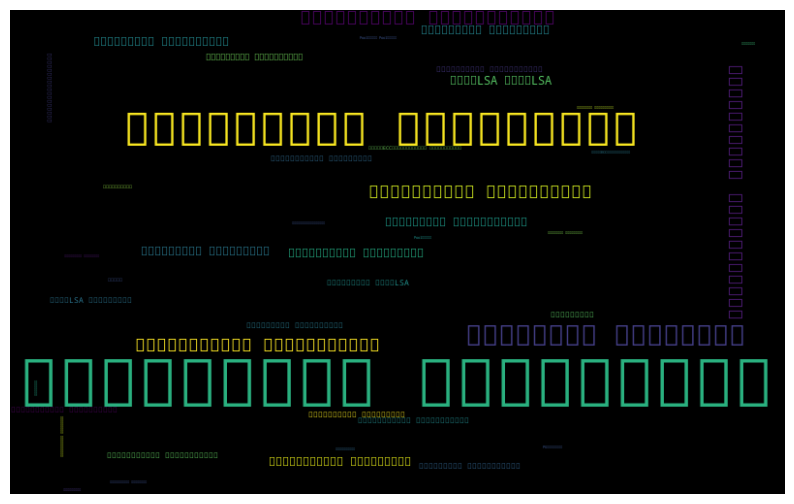

In [14]:
word_cloud(cluster_df,0)

In [ ]:
word_cloud(cluster_df,1)

In [ ]:
word_cloud(cluster_df,2)

In [ ]:
word_cloud(cluster_df,3)

In [ ]:
word_cloud(cluster_df,4)

In [15]:
clustered_sentences[1]

['转发面端口DOWN',
 '转发面端口DOWN',
 '两端MLAG成员口down告警',
 '物理机以太网口DOWN',
 '物理机以太网口DOWN',
 '两端MLAG成员口down告警',
 '物理机以太网口DOWN',
 '物理机以太网口DOWN',
 '物理机以太网口DOWN',
 '物理机以太网口DOWN',
 '以太网口LACP协议down',
 '物理机以太网口DOWN',
 '以太网口LACP协议down',
 '物理机以太网口DOWN',
 '物理机以太网口DOWN',
 '以太网口LACP协议down',
 '物理机以太网口DOWN',
 '物理机以太网口DOWN',
 '以太网口LACP协议down',
 '以太网口LACP协议down',
 '以太网口LACP协议down',
 '以太网口LACP协议down',
 '以太网口LACP协议down',
 '物理机以太网口DOWN',
 '物理机以太网口DOWN',
 'Trunk所有成员口都Down',
 '以太网口LACP协议down',
 'LDP会话down',
 '以太网口LACP协议down',
 '物理机以太网口DOWN',
 '物理机以太网口DOWN',
 '物理机以太网口DOWN',
 '物理机以太网口DOWN',
 '物理机以太网口DOWN',
 '物理机以太网口DOWN',
 'Trunk所有成员口都Down',
 '以太网口LACP协议down',
 '物理机以太网口DOWN',
 '物理机以太网口DOWN',
 '物理机以太网口DOWN',
 '物理机以太网口DOWN',
 '以太网口LACP协议down',
 '以太网口LACP协议down',
 '物理机以太网口DOWN',
 '以太网口LACP协议down',
 '两端MLAG成员口down告警',
 '两端MLAG成员口down告警',
 '转发面端口DOWN',
 'BFD会话状态为Down',
 '转发面端口DOWN',
 '转发面端口DOWN',
 '两端MLAG成员口down告警',
 '两端MLAG成员口down告警',
 '两端MLAG成员口down告警',
 'Trunk所有成员口都Down',
 '两端MLAG成员口down告警',
 '两端MLAG成员口down告警',
 '两端MLAG成